In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from scipy import stats, signal
from loading import load_session_data
from target import build_tgt_matrix, get_spike_counts, build_silence_and_noise_events,\
        get_idxs_of_event_periods, build_silence_matrix, get_spike_times_at
np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def get_pop_resp_profile_mx(session, hw, bc):
    animal      = session.split('_')[0]
    h5_file     = os.path.join(source, animal, session, session + '.h5')
    with h5py.File(h5_file, 'r') as f:
        unit_names = [x for x in f['units']]
            
    bins = np.linspace(-hw, hw, bc)
    profile_mx = np.zeros([len(unit_names), bc - 1])
    for i, unit_name in enumerate(unit_names):
        with h5py.File(h5_file, 'r') as f:
            shuffled = np.array(f['units'][unit_name]['psth_shuffled_micro_in_silence'])
            profiles = np.array(f['units'][unit_name]['psth_profiles_silence'])

        fr_mean = shuffled[:, 1]
        fr_std  = shuffled[:, 2]
        fr_prof = profiles.mean(axis=0)
        profile_mx[i] = (fr_prof - fr_mean)/fr_std  # z-scored
        
    return profile_mx, bins

In [5]:
def get_unit_AM_for_periods(tl, periods, pulses_silence, spike_times, bin_size=0.05/3, shuffle=False):
    # overlay for each unit!!
    # pulses for each silence period (list of arrays)
    pulses_by_period = get_spike_times_at(tl, pulses_silence, periods, mode='overlay')
    shifts = [p[0] if len(p) > 0 else 0 for p in pulses_by_period]  # shifts to align all pulses

    # first align all pulses
    adj_pulses = []
    for i, pulses in enumerate(pulses_by_period):
        if len(pulses) > 0:
            adj_pulses.append(pulses - shifts[i])
        else:
            adj_pulses.append([])
    max_l_idx = np.array([len(x) for x in adj_pulses]).argmax()  # take the longest pulse train
    pulses_over = adj_pulses[max_l_idx]

    # create empty AM and binning
    bc_amx   = int(pulses_over[-1]/bin_size)
    bins_amx = np.linspace(0, bin_size*bc_amx, bc_amx)
    unit_AM  = np.zeros([len(spike_times.keys()), len(bins_amx) - 1])

    # then overlay and align all spiketrains
    for i, (unit_name, all_spikes) in enumerate(spike_times.items()):
        # spikes for each silence period  (list of arrays)
        spikes_by_period = get_spike_times_at(tl, all_spikes, periods, mode='overlay')

        adj_spikes = []
        for j, spikes in enumerate(spikes_by_period):
            if len(spikes) > 0:
                adj_spikes.append(spikes - shifts[j])
            else:
                adj_spikes.append([])

        # combine all spikes in overlayed spiketrain
        spikes_over = np.array([item for sublist in adj_spikes for item in sublist])  # flatten to one array
        spikes_over = np.sort(spikes_over)

        # convert overlayed spike times into binned FR (60 Hz)
        spikes_binned, _ = np.histogram(spikes_over, bins=bins_amx)
        spikes_binned = stats.zscore(spikes_binned)
        unit_AM[i] = spikes_binned
        
    return pulses_over, unit_AM, bins_amx

In [6]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions

['009266_hippoSIT_2023-04-13_08-57-46',
 '009266_hippoSIT_2023-04-14_09-17-34',
 '009266_hippoSIT_2023-04-17_09-06-10',
 '009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_09-11-06',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [7]:
session = sessions[3]
session

'009266_hippoSIT_2023-04-17_17-04-17'

In [8]:
session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
aeps_events = session_data['aeps_events']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
h5_file = session_data['h5_file']
session

'009266_hippoSIT_2023-04-17_17-04-17'

## Dev: AM for all units

In [13]:
# all silence fake pulses
s_offset, latency = aeps_events[0][0], 0.25
drift = ((aeps_events[:, 0] - s_offset) % latency)[-1]
pulses_silence, pulses_noise = build_silence_and_noise_events(tl, s_offset, latency, drift)

event_type = 0  # silence
periods = get_idxs_of_event_periods(tl, event_type)

hw   = 0.25
bc   = 31
profile_mx, bins_prof = get_pop_resp_profile_mx(session, hw, bc)
# reduce noise?
#profile_mx[np.abs(profile_mx) < 1] = 0
profile_mx_half = profile_mx[:, 15:]

pulses_over, unit_AM, bins_amx = get_unit_AM_for_periods(tl, periods, pulses_silence, spike_times, bin_size=0.05/3, shuffle=False)

In [14]:
# check for single unit
unit_idx = 11
prof = profile_mx_half[unit_idx]
spks = unit_AM[unit_idx]

sig_CCR = signal.correlate(spks, prof, mode='same')

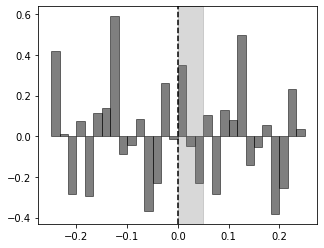

In [17]:
rec_count = len(pulses_over) - 3
psth_sig = np.zeros([rec_count, 30])
for i in np.arange(rec_count) + 1:
    psth_sig[i-1] = sig_CCR[i*15 - 15:i*15 + 15]    
psth_sig_mean = psth_sig.sum(axis=0)/len(psth_sig)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(bins_prof[:-1], bins=bins_prof, weights=psth_sig_mean, edgecolor='black', color='black', alpha=0.5, label='All')
ax.axvline(0, color='black', ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')

In [18]:
# create shuffled unit AM
unit_AM_shuf = unit_AM.copy().T
np.random.shuffle(unit_AM_shuf)
unit_AM_shuf = unit_AM_shuf.T
unit_AM_shuf.shape

(27, 1769)

In [19]:
# CCR matrix for all units
CCR_mx = np.zeros(unit_AM.shape)
for unit_idx in range(len(profile_mx_half)):
    prof = profile_mx_half[unit_idx]
    spks = unit_AM[unit_idx]
    #spks = unit_AM_shuf[unit_idx]
    CCR_mx[unit_idx] = signal.correlate(spks, prof, mode='same')

Text(0.5, 0, 'Time in silence, bins')

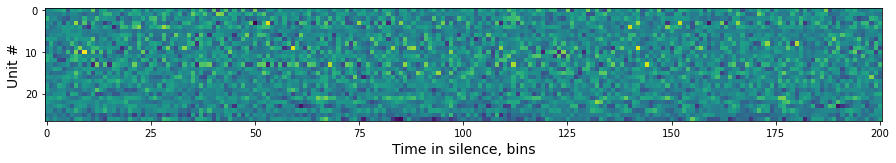

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.imshow(CCR_mx[:, 0:201])
ax.set_ylabel('Unit #', fontsize=14)
ax.set_xlabel('Time in silence, bins', fontsize=14)  

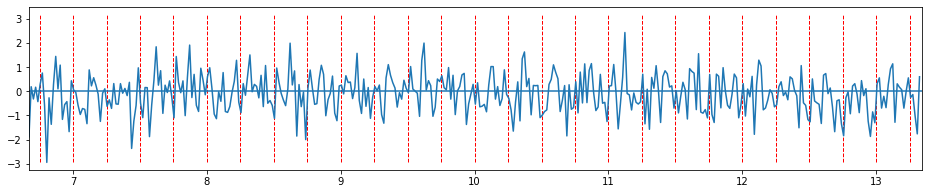

In [22]:
sig = CCR_mx.mean(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
x_l, x_r = 400, 800
ax.plot(bins_amx[x_l:x_r], sig[x_l:x_r])
ax.vlines(pulses_over, sig.min(), sig.max(), color='red', lw=1, ls='--')
ax.set_xlim(bins_amx[x_l], bins_amx[x_r])
ax.axhline(0)

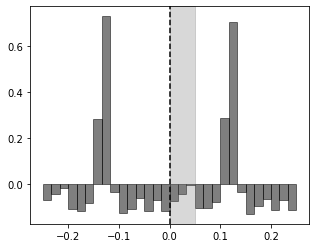

In [29]:
# PSTH for CCR
rec_count = len(pulses_over) - 3
psth_sig = np.zeros([rec_count, 30])
for i in np.arange(rec_count) + 1:
    psth_sig[i-1] = sig[i*15 - 15:i*15 + 15]    
psth_sig_mean = psth_sig.sum(axis=0)/len(psth_sig)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(bins_prof[:-1], bins=bins_prof, weights=psth_sig_mean, edgecolor='black', color='black', alpha=0.5, label='All')
ax.axvline(0, color='black', ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')

## Dev: single unit CCRs

In [30]:
unit_name = '1-2'

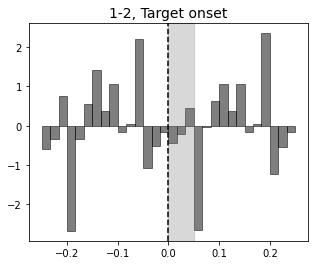

In [32]:
# plot profile
with h5py.File(h5_file, 'r') as f:
    shuffled = np.array(f['units'][unit_name]['psth_shuffled_micro_in_silence'])
    profiles = np.array(f['units'][unit_name]['psth_profiles_silence'])

fr_mean = shuffled[:, 1]
fr_std  = shuffled[:, 2]
fr_prof = profiles.mean(axis=0)
profile_full = (fr_prof - fr_mean)/fr_std  # z-scored
profile_half = profile_full[15:]

#prof_h = np.zeros(len(prof))
#idxs = np.where((prof > 2) | (prof < -5))[0]
#prof_h[idxs] = prof[idxs]

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(bins_prof[:-1], bins=bins_prof, weights=profile_full, edgecolor='black', color='black', alpha=0.5, label='All')
#ax.hist(bins[:-1], bins=bins, weights=fr_prof, edgecolor='black', color='black', alpha=0.5, label='All')
ax.axvline(0, color='black', ls='--')
ax.set_title("%s, Target onset" % unit_name, fontsize=14)
ax.axvspan(0, 0.05, alpha=0.3, color='gray')

### Building overlayed activity matrix

In [33]:
# all silence fake pulses
s_offset, latency = aeps_events[0][0], 0.25
drift = ((aeps_events[:, 0] - s_offset) % latency)[-1]
pulses_silence, pulses_noise = build_silence_and_noise_events(tl, s_offset, latency, drift)

# pulses for each silence period (list of arrays)
pulses_by_period = get_spike_times_at(tl, pulses_silence, periods, mode='overlay')

# spikes for each silence period  (list of arrays)
spikes_by_period = get_spike_times_at(tl, spike_times[unit_name], periods, mode='overlay')

adj_pulses, adj_spikes = [], []
for i, period in enumerate(periods):
    if len(pulses_by_period[i]) > 0:
        shift = pulses_by_period[i][0]
        adj_pulses.append(pulses_by_period[i] - shift)
        adj_spikes.append(spikes_by_period[i] - shift)
        
# take the longest pulse train
max_l_idx = np.array([len(x) for x in adj_pulses]).argmax()
pulses_over = adj_pulses[max_l_idx]

# combine all spikes in overlayed spiketrain
spikes_over = np.array([item for sublist in adj_spikes for item in sublist])  # flatten to one array
spikes_over = np.sort(spikes_over)

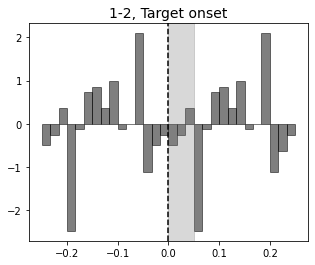

In [34]:
# PSTH for spike times for OVERLAYED periods (should match the profile)
bins, counts = get_spike_counts(spikes_over, pulses_over, hw=0.25, bin_count=31)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(bins_prof[:-1], bins=bins_prof, weights=stats.zscore(counts), edgecolor='black', color='black', alpha=0.5, label='All')
#ax.hist(bins[:-1], bins=bins, weights=counts, edgecolor='black', color='black', alpha=0.5, label='All')
ax.axvline(0, color='black', ls='--')
ax.set_title("%s, Target onset" % unit_name, fontsize=14)
ax.axvspan(0, 0.05, alpha=0.3, color='gray')

Text(0.5, 0, 'Time, s')

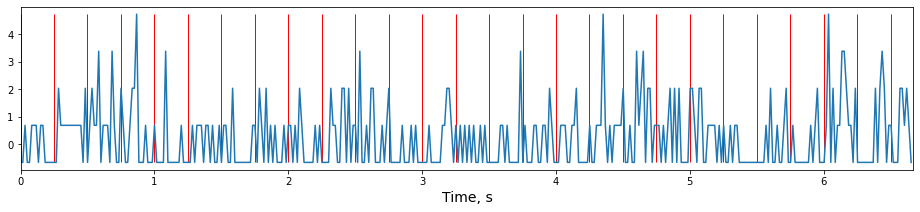

In [35]:
# convert overlayed spike times into binned FR (60 Hz)
bin_size = 0.05/3  # in sec, same for profiles
bc_amx   = int(pulses_over[-1]/bin_size)
bins_amx = np.linspace(0, bin_size*bc_amx, bc_amx)

spikes_binned, _ = np.histogram(spikes_over, bins=bins_amx)
spikes_binned = stats.zscore(spikes_binned)

b_l, b_r = 0, 400
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(bins_amx[b_l:b_r], spikes_binned[b_l:b_r])
ax.vlines(pulses_over, spikes_binned.min(), spikes_binned.max(), color='red', lw=1)
ax.set_xlim(bins_amx[b_l], bins_amx[b_r])
ax.set_xlabel("Time, s", fontsize=14)

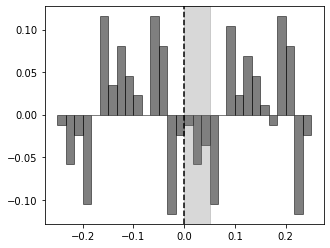

In [36]:
# PSTH for binned spiketrain - should roughly match the profile
rec_count = len(pulses_over) - 3
psth_spk_bin = np.zeros([rec_count, 30])
for i in np.arange(rec_count) + 1:
    psth_spk_bin[i-1] = spikes_binned[i*15 - 15:i*15 + 15]    
psth_spk_mean = psth_spk_bin.sum(axis=0)/len(psth_spk_bin)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(bins_prof[:-1], bins=bins_prof, weights=psth_spk_mean, edgecolor='black', color='black', alpha=0.5, label='All')
ax.axvline(0, color='black', ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')

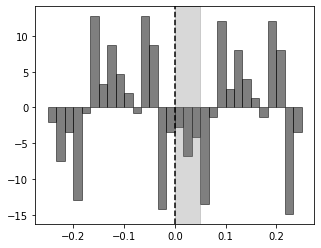

In [37]:
# create the same by CCR with 0/1 PULSE TRAIN, just to see the CCR
pulse_train = np.zeros(len(bins_amx))
pulse_train[::15] = 1

s_rate = 60
t_lag  = 0.25
i_rate = spikes_binned
var_tl = pulse_train
corr = signal.correlate(i_rate, var_tl)
lags = signal.correlation_lags(len(var_tl), len(i_rate))

idx_l, idx_r = int(len(lags)/2) - int(t_lag*s_rate), int(len(lags)/2) + int(t_lag*s_rate)
bins_ccr = lags[idx_l-1:idx_r]/60
sig_ccr  = corr[idx_l:idx_r]

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(bins_ccr[:-1], bins=bins_ccr, weights=sig_ccr, edgecolor='black', color='black', alpha=0.5, label='All')
ax.axvline(0, color='black', ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')

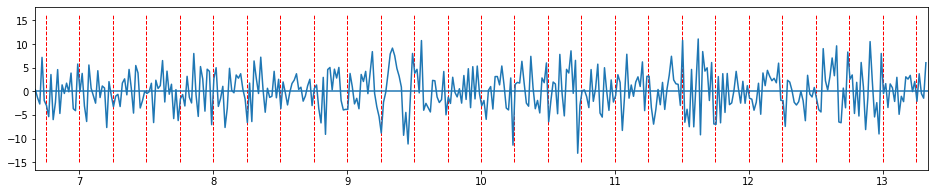

In [38]:
# NOW try to corr with profile kernel
spikes_shuf = spikes_binned.copy()
np.random.shuffle(spikes_shuf)

sig = signal.correlate(spikes_binned, profile_half, mode='same')
#sig = signal.correlate(spikes_shuf, profile_half, mode='same')

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
x_l, x_r = 400, 800
ax.plot(bins_amx[x_l:x_r], sig[x_l:x_r])
ax.vlines(pulses_over, sig.min(), sig.max(), color='red', lw=1, ls='--')
ax.set_xlim(bins_amx[x_l], bins_amx[x_r])
ax.axhline(0)

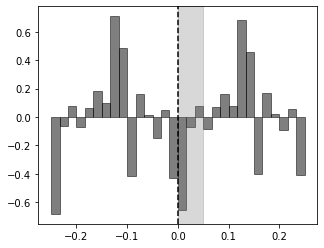

In [39]:
rec_count = len(pulses_over) - 3
psth_sig = np.zeros([rec_count, 30])
for i in np.arange(rec_count) + 1:
    psth_sig[i-1] = sig[i*15 - 15:i*15 + 15]    
psth_sig_mean = psth_sig.sum(axis=0)/len(psth_sig)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(bins_prof[:-1], bins=bins_prof, weights=psth_sig_mean, edgecolor='black', color='black', alpha=0.5, label='All')
ax.axvline(0, color='black', ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')